# HerPal , Empowering Girls with Safety and Care


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

## Load your dataset


In [2]:
dataset = image_dataset_from_directory(
    'data',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 298 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['menstrual_cup_data', 'sanitary_pad_data', 'tampon_data']

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 2 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 2 1 1 1 2 1 0 1 2 0 1 1 2 0]


## Visualize some of the images from our dataset

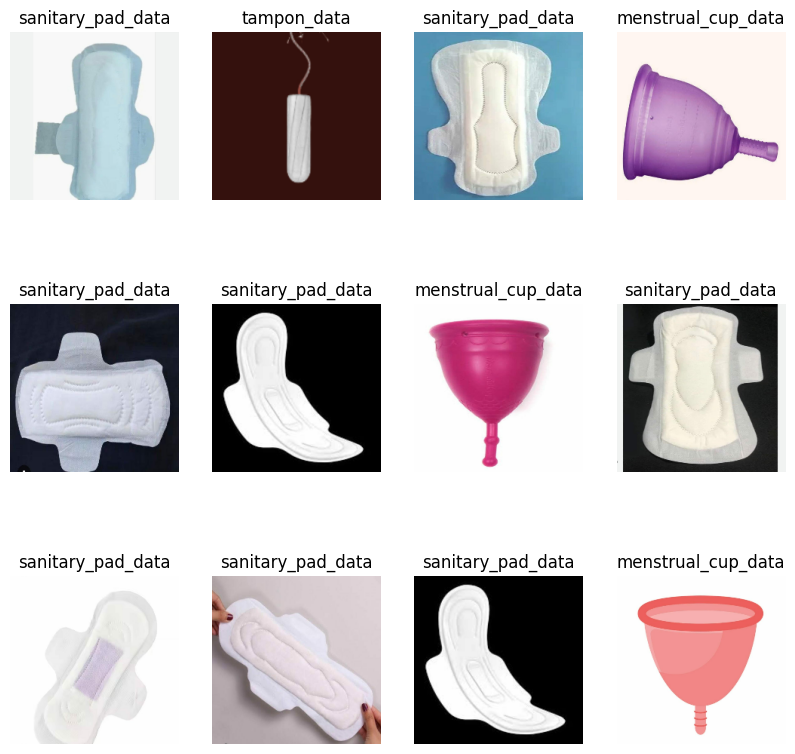

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Split the dataset into training and validation sets (80% train, 20% validation)

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Print the sizes of the training and validation datasets
print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

Training dataset size: 8
Validation dataset size: 2


# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [7]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [8]:
# Preprocessing function
def preprocess_input(image):
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    # Use the MobileNetV2 preprocess function
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  
    return image

# Verify input shapes
for images, labels in train_dataset.take(1):
    print("Shape before augmentation:", images.shape)
    augmented_images = data_augmentation(images)
    print("Shape after augmentation:", augmented_images.shape)
    
    # Apply preprocessing to each augmented image
    processed_images = tf.map_fn(preprocess_input, augmented_images)
    print("Shape after preprocessing:", processed_images.shape)

Shape before augmentation: (32, 224, 224, 3)
Shape after augmentation: (32, 224, 224, 3)
Shape after preprocessing: (32, 224, 224, 3)


# Building Model with MobileNetV2

MobileNetV2 is a pre-trained convolutional neural network model . Key reasons for using MobileNetV2 in our model include:

Pre-trained Weights: It comes with weights pre-trained on the ImageNet dataset, allowing us to leverage transfer learning. This significantly boosts model performance, especially when we have limited training data, as it helps the model learn from previously established features.

Lightweight Architecture: Designed for computational efficiency, MobileNetV2 ensures faster inference times, making it suitable for real-time applications on resource-constrained devices.

Depthwise Separable Convolutions: This architecture reduces the number of parameters and computations, leading to quicker training and lower memory usage.

Adaptability: MobileNetV2 supports various input sizes, making it versatile for different applications.

In [9]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(3, activation='softmax')  # Output layer for binary classification
])

# Print model summary to understand the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ ?                           │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## train the model

In [ ]:
history = model.fit(
    train_dataset.map(lambda x, y: (tf.map_fn(preprocess_input, x), y)), 
    validation_data=val_dataset.map(lambda x, y: (tf.map_fn(preprocess_input, x), y)),
    epochs=10  # Adjust epochs as needed
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7285 - loss: 0.6091 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 2/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 1.0000 - loss: 0.0049

In [ ]:
# Print training history for accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(f"Training Accuracy: {accuracy[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")

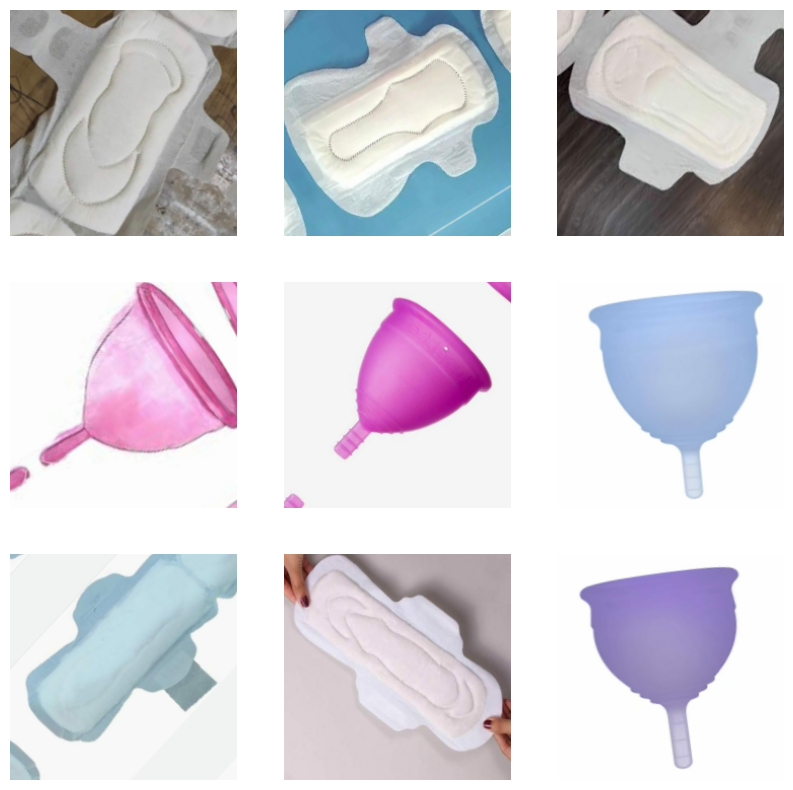

In [19]:
#  Visualize some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()